In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
from PIL import Image

import torch
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset
from torch import nn
import torchvision.models as torchmodels


from fastai.distributed import *
from fastai.vision.all import *

from accelerate import notebook_launcher
from accelerate.utils import write_basic_config

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# df = pd.read_csv(data_dir/'down.csv')
# df.object_2 = 'None'
# df.to_csv(data_dir/'down.csv')

In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [7]:
# write_basic_config()

In [8]:
data_dir = Path('data_v4'); assert data_dir.exists()

In [9]:
categories = [Path(cat).stem for cat in os.listdir(data_dir) if cat.endswith('.csv')]
categories, len(categories)

(['into_hole',
  'over',
  'against',
  'inside',
  'outside',
  'out',
  'with',
  'down',
  'against_leaning',
  'on',
  'up',
  'between',
  'all_over',
  'towards',
  'above',
  'among',
  'behind',
  'along',
  'around_surround',
  'below',
  'by',
  'into_crash',
  'from',
  'front',
  'off',
  'beside',
  'around',
  'through',
  'onto',
  'along_position'],
 30)

In [10]:
def get_color_and_object(obj_str:str):
    color, object_name = ''.join(obj_str.split()[:-1]),obj_str.split()[-1]
#     return self.colors_to_index[color], self.objects_to_index[object_name]
    return color, object_name

In [11]:
def noop(x): return x

gonna have to create dataset in the fastai environment

In [12]:
class dataset_oracle(Dataset):
    def __init__(self, data_dir = data_dir, transform:list = None, y_transform:list = None, frames_per_vid=10, sampling = 'uniform'):
        f'''
        frames_per_vid: how many frames to consider per video for a data sample x. 
                        Per video, frames_per_vid images will be returned, using a sampling. Eg, if sampling = 'uniform', 10 uniformly spaced images will be returned. 
        sampling :      "uniform" by default, other values: "start", "end". if uniform, images will be uniformly returned (including the starting and ending images). If start, the first 10 images will be returned, 
                        if end, from the end
        '''
        super().__init__()
        self.data_dir = Path(data_dir)
        
        self.vocab = [Path(cat).stem for cat in os.listdir(data_dir) if cat.endswith('.csv')]
        self.class_to_index = {cat:i for i,cat in enumerate(self.vocab)}
        self.index_to_class = {self.class_to_index[cat]:cat for cat in self.vocab}
        
        self.c = len(self.vocab)
        
        self.frame_lim = frames_per_vid #only the last frames_per_vid 
        assert sampling in ('uniform', 'start', 'end'), f"invalid sampling technique. choose from 'uniform', 'start' or 'end'"
        self.sampling = sampling
        
        self.transforms = list(transform) if transform is not None else [self.sample, lambda x: x.float(), lambda x: torch.transpose(x,1,0)]
        self.y_transforms = list(y_transform) if y_transform is not None else [lambda x: self.class_to_index[x]]
        
        self.videos = [f for f in get_files(data_dir, extensions=['.mp4']) if f.parent.stem in self.vocab]
        
#         self.objects = ['None', 'Arch', 'Capsule', 'Cone', 'Cube', 'Cylinder', 'Pipe', 'Prism', 'Sphere', 'Torus', 'Circular_container', 'Octagonal_pipe', 'Square_container', 'Torus_container'] #None means there is no object there
#         self.colors = ['None', 'red', 'green', 'darkblue', 'purple', 'lightblue', 'orange', 'darkgrey', 'yellow'] #none means there is no object present
        self.colors, self.objects = self._get_color_and_object_list(self.data_dir)
    
        self.objects_to_index = {cat:i for i,cat in enumerate(self.objects)}
        self.colors_to_index = {cat:i for i,cat in enumerate(self.colors)}
    
    def __len__(self): return len(self.videos)
    
    def __getitem__(self, idx):
        x, _, _ = read_video(str(self.videos[idx]), output_format="TCHW")
        x=self.apply_tfm(x,self.transforms)
        
        y=self.apply_tfm(self.videos[idx].parent.stem, self.y_transforms)
    
        df_info = pd.read_csv(data_dir/f'{self.videos[idx].parent.stem}.csv')
        obj1_val, obj2_val = df_info.loc[df_info['video_file_name']==str(self.videos[idx].name)][['object_1', 'object_2']].values[0]
        
        color1, obj1 = get_color_and_object(obj1_val)
        color2, obj2 = get_color_and_object(obj2_val)
        
        assert color1 in self.colors and color2 in self.colors, f'{color1} or {color2} is an invalid color'
        assert obj1 in self.objects and obj2 in self.objects, f'{obj1} or {obj2} is an invalid object name'
           
        return (x,(self.colors_to_index[color1], self.objects_to_index[obj1], self.colors_to_index[color2], self.objects_to_index[obj2])),y
                         
                         
    def apply_tfm(self, x, tfm_list):
        for tfm in tfm_list: x = tfm(x)
        return x
                       
    def sample(self, frames):
        if self.sampling=='uniform':  return frames[[int(i*(len(frames)-1)/(self.frame_lim-1)) for i in range(self.frame_lim)]]
        elif self.sampling=='start': return frames[:self.frame_lim]
        elif self.sampling=='end': return frames[len(frames)-self.frame_lim:]

    #helper functions for getting attributes from csv files
    
    def _is_container(self,obj):
        assert obj in self.objects
        return obj.contains('_')
    
    def _get_color_and_object_list(self, data_dir, obj1_name = 'object_1', obj2_name='object_2'):
        colors = set()
        object_names = set()
        for f in get_files(data_dir, extensions = ['.csv']):
            df = pd.read_csv(f)
            obj1_list = df[obj1_name].tolist()
            obj2_list = df[obj2_name].tolist()
            for obj_list in [obj1_list, obj2_list]:
                for v in obj_list:
                    c1, o1 = get_color_and_object(v)
                    if c1 not in colors: colors.add(c1) 
                    if o1 not in object_names: object_names.add(o1)
        
        return list(colors), list(object_names)
    

In [13]:
data = dataset_oracle(data_dir); len(data)

30000

In [14]:
len(data.colors), len(data.objects)

(9, 15)

In [15]:
(x, objs_info),y = next(iter(data))
x.shape, y, objs_info

(torch.Size([3, 10, 512, 512]), 11, (3, 11, 5, 14))

In [16]:
train_split = 0.8
train_ds, test_ds = torch.utils.data.random_split(data, [int(len(data)*train_split), len(data) - int(len(data)*train_split)])

In [17]:
from torch.utils.data import DataLoader

In [18]:
def get_batch_size(frames_per_vid, max_effective_batch_size = 100):
    bs_ideal = max_effective_batch_size//frames_per_vid
    #this value can be a batch_size, but we want the nearest lower power of 2 as the batch size for efficiency purposes
    pow=1
    while True:
        if pow*2<=bs_ideal: pow*=2
        else: return pow

In [19]:
#batch_size
bs = get_batch_size(data.frame_lim, max_effective_batch_size = 100)
bs

8

In [20]:
train_dl = DataLoader(train_ds, batch_size =bs , shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 2*bs, shuffle = True)
dls = DataLoaders(train_dl, test_dl)

In [21]:
%time (x, objs_info),y = next(iter(train_dl))
x.shape, y, objs_info

CPU times: user 1.96 s, sys: 178 ms, total: 2.14 s
Wall time: 491 ms


(torch.Size([8, 3, 10, 512, 512]),
 tensor([ 2,  8, 29, 23,  2, 12, 20,  4]),
 [tensor([7, 6, 6, 2, 6, 5, 8, 1]),
  tensor([ 4,  5,  0,  9,  0,  5,  9, 11]),
  tensor([4, 8, 1, 6, 2, 0, 7, 6]),
  tensor([11,  0, 13, 14,  1,  8, 10,  2])])

# Model

What if we used a pretrained model?

In [22]:
r3d_18 = torchmodels.video.r3d_18(weights = 'KINETICS400_V1')
r3d_18.fc = nn.Linear(in_features = 512, out_features=data.c)
# r3d_18 = r3d_18.to(device)

In [23]:
r3d_18

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [24]:
# %%notify
# dls = DataLoaders(train_dl, test_dl)
# learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
# learn.lr_find()

In [25]:
from torchvision.models.video.resnet import VideoResNet
class custom_model(nn.Module):
    
    def __init__(self, model, data, include_objects = False, include_colors = False):
        super().__init__()
        
        self.stem = model.stem
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

        self.avgpool = model.avgpool
#         self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self.include_colors = include_colors
        self.include_objects = include_objects
        
        if self.include_objects:
            self.objs = len(data.objects)
            self.obj_embedding =   nn.Embedding(len(data.objects), 128)
            
        if self.include_colors:
            self.colors = len(data.colors)
            self.color_embedding = nn.Embedding(len(data.colors), 128)

        self.fc = nn.Linear(in_features = 512 + 256*int(self.include_objects) + 256*int(self.include_colors)  , out_features=data.c)
#         
        
    def forward(self, x):
        x,obj_info = x
        c1,o1,c2,o2 = obj_info
        
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.flatten(1)

        if self.include_objects:  
            o1_emb, o2_emb = self.obj_embedding(o1), self.obj_embedding(o2)            
            x = torch.cat((x,o1_emb, o2_emb), dim=1)
            
        if self.include_colors: 
            c1_emb, c2_emb = self.color_embedding(c1), self.color_embedding(c2)
            x = torch.cat((x,c1_emb, c2_emb), dim=1)
            
        x = self.fc(x)
        return x
# .resnet import VideoResNet

In [26]:
r3d_18 = torchmodels.video.r3d_18(weights = None)#'KINETICS400_V1')
model_info = custom_model(r3d_18,data, include_objects = True, include_colors = True)
model_info

custom_model(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1)

In [27]:
dls = DataLoaders(train_dl, test_dl)
learn = Learner(dls, model = model_info.to(device), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
# learn.lr_find()

In [28]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.261809,0.298351,0.886500,2:15:36


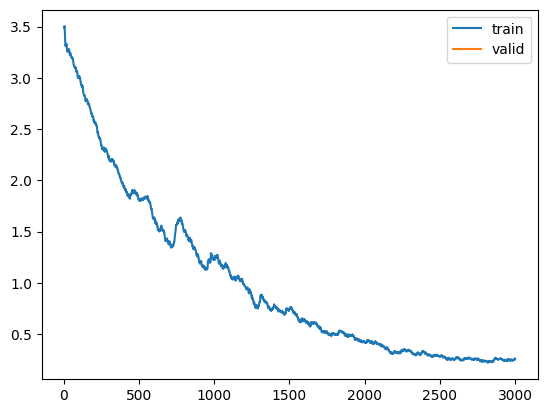

In [32]:
learn.recorder.plot_loss()

In [ ]:
%%notify

In [ ]:
test_dl.vocab = [data.vocab] #theres a bug in fastai, it 
interpret = ClassificationInterpretation.from_learner(learn, dl =test_dl)

In [ ]:
learn.plot_losses()

In [ ]:
interpret.plot_confusion_matrix()

In [ ]:
interpret.most_confused()

# Modified R3d

## Training iterations

1. only objects, no color. Embedding = 256+256
2. object + color. Embedding = 128 + 128 + 128 +128
3. 

In [ ]:
for module in list(r3d_18.modules()): 
    print('hoya')
    print(module)
